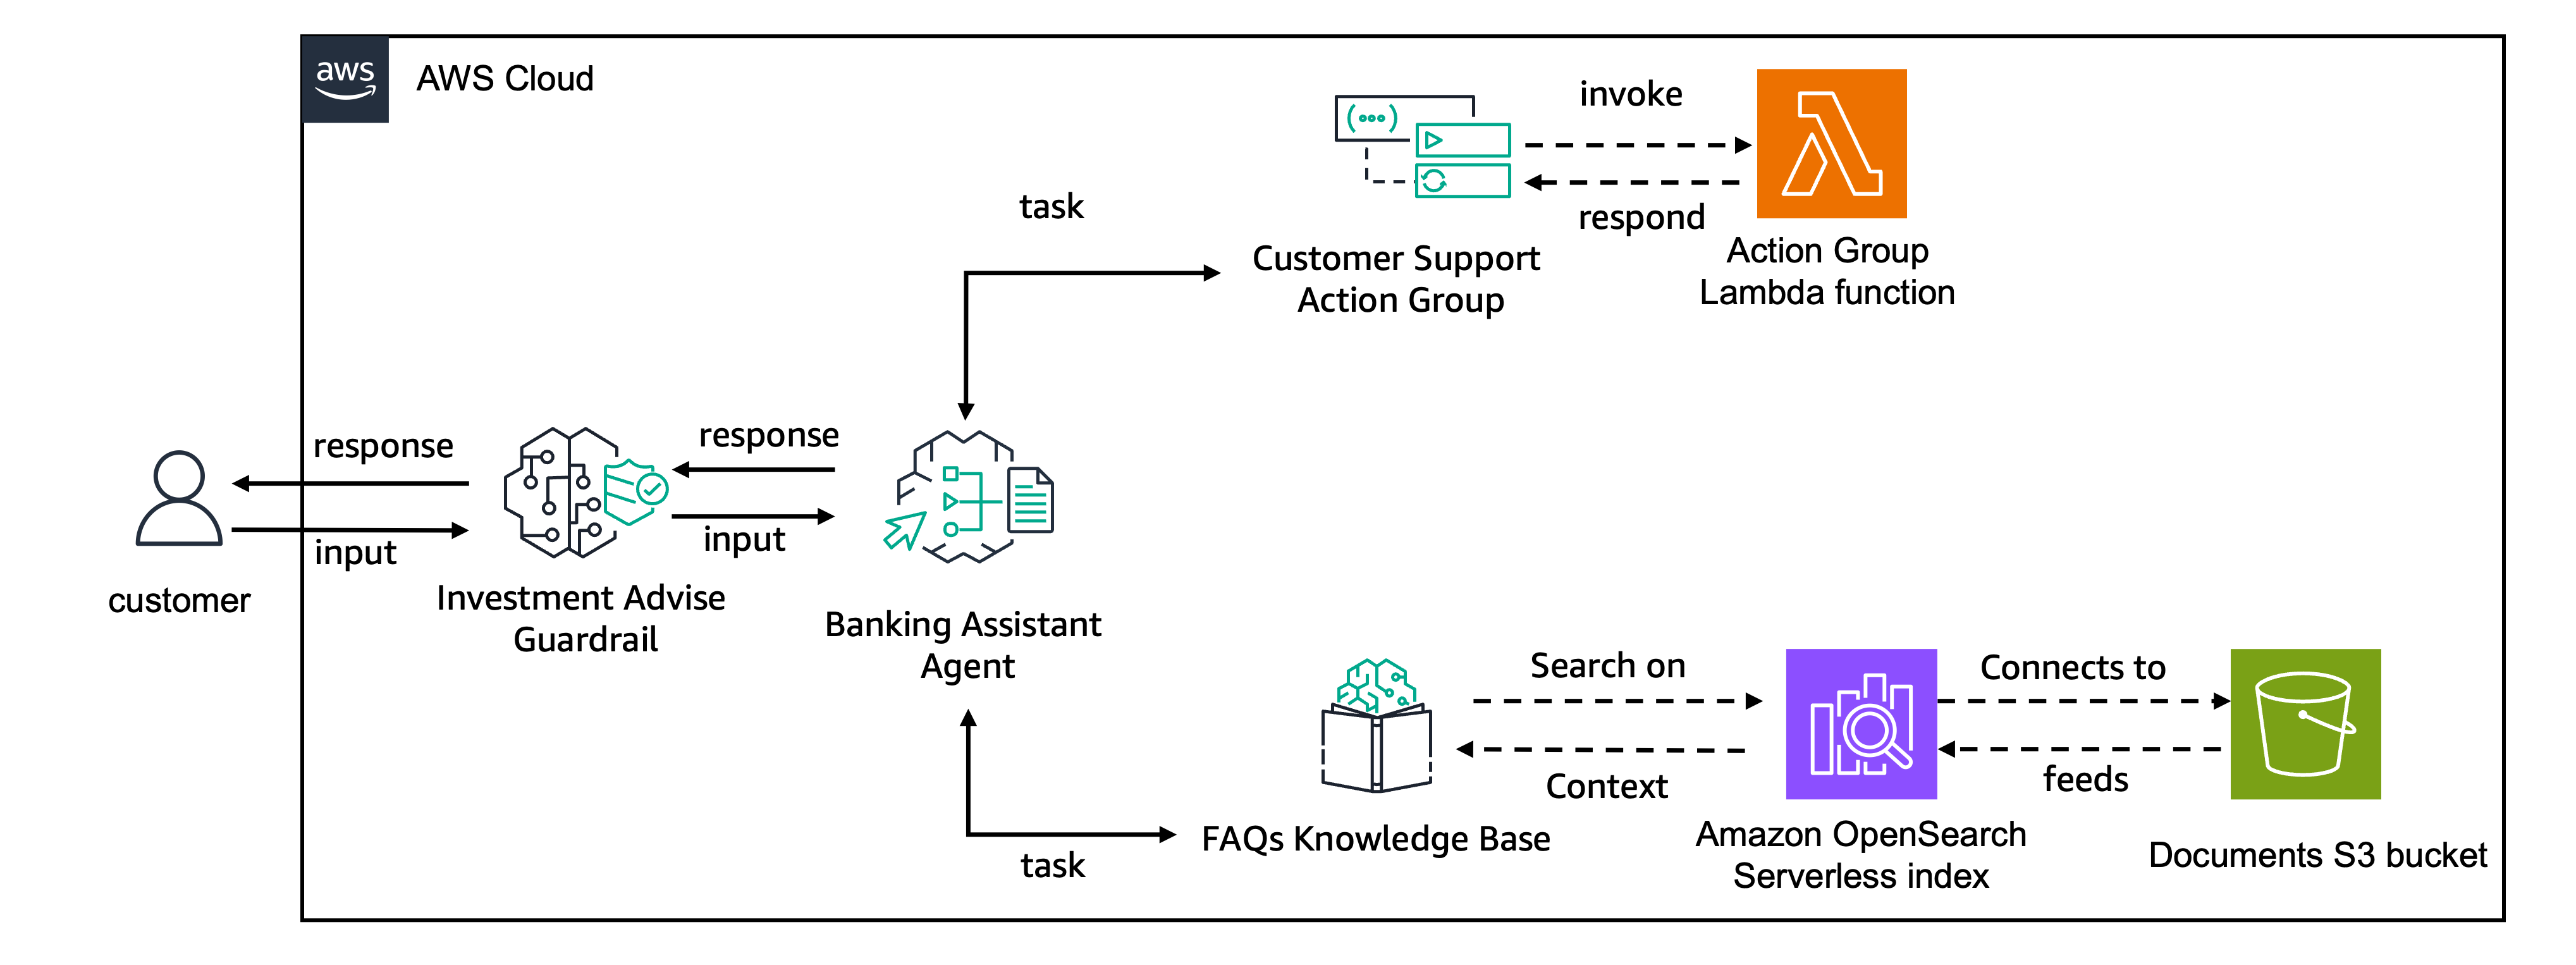

In [ ]:
!python3 -m pip install -r requirements.txt

In [2]:
import os
import time
import boto3
import logging
import pprint
import json

from knowledge_base import KnowledgeBasesForAmazonBedrock
from agent import AgentsForAmazonBedrock

In [3]:
#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')
bedrock_client = boto3.client('bedrock')
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
region, account_id

('us-east-1', '442120074911')

In [4]:
suffix = f"{region}-{account_id}"
agent_name = 'banking-assistant1q11'
knowledge_base_name = f'{agent_name}-kb'
knowledge_base_description = "Knowledge Base that provides FAQ documentation for the banking assistant agent"
agent_alias_name = "banking-agent-alias"
bucket_name = f'{agent_name}-{suffix}'
agent_bedrock_allow_policy_name = f"{agent_name}-ba"
agent_role_name = f'AmazonBedrockExecutionRoleForAgents_{agent_name}'
agent_foundation_model = "amazon.nova-pro-v1:0"

agent_description = "Online Banking assistant agents"
agent_instruction = """
You are an agent designed to assist customers from the ANY_BANK Corporation with online banking queries. 
You ALWAYS reply politely and concise using ONLY the available information in the ba_kb knowledge base or the data retrieved via the banking-assistant action group.

You also add the name ANY_BANK Corporation to your first answer in a session. You should start with an acknowledgement of the customer's query and thanking the customer for contacting you.

Introduce yourself as the "ANY_BANK Corporation AI Assistant".

NEVER provide account balances or book appointments without first confirming the customer's user_id
"""

### Create Knowledge Base for Amazon Bedrock

In [5]:
knowledge_base = KnowledgeBasesForAmazonBedrock()
kb_id, ds_id = knowledge_base.create_or_retrieve_knowledge_base(
    knowledge_base_name, knowledge_base_description, data_bucket_name=bucket_name
)

[2025-05-31 09:49:01,528] p73417 {credentials.py:1352} INFO - Found credentials in shared credentials file: ~/.aws/credentials
[2025-05-31 09:49:04,347] p73417 {credentials.py:1352} INFO - Found credentials in shared credentials file: ~/.aws/credentials


Creating KB banking-assistant1q11-kb
Step 1 - Creating or retrieving banking-assistant1q11-us-east-1-442120074911 S3 bucket for Knowledge Base documents
Creating bucket banking-assistant1q11-us-east-1-442120074911
Step 2 - Creating Knowledge Base Execution Role (AmazonBedrockExecutionRoleForKnowledgeBase_1307) and Policies
Step 3 - Creating OSS encryption, network and data access policies
Step 4 - Creating OSS Collection (this step takes a couple of minutes to complete)
{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '321',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Sat, 31 May 2025 04:19:11 '
                                                 'GMT',
                                         'x-amzn-requestid': '5ea4db49-819b-4268-ad7b-ab3f6460f6c3'},
                        'HTTPStatusCode': 200,
                    

[2025-05-31 09:53:47,906] p73417 {base.py:258} INFO - PUT https://jolvnlh6eefkn6r2sg99.us-east-1.aoss.amazonaws.com:443/banking-assistant1q11-kb-index-1307 [status:200 request:1.709s]



Creating index:
{ 'acknowledged': True,
  'index': 'banking-assistant1q11-kb-index-1307',
  'shards_acknowledged': True}
Step 6 - Creating Knowledge Base
{'type': 'VECTOR', 'vectorKnowledgeBaseConfiguration': {'embeddingModelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-text-v2:0'}}
{ 'createdAt': datetime.datetime(2025, 5, 31, 4, 24, 48, 821397, tzinfo=tzutc()),
  'description': 'Knowledge Base that provides FAQ documentation for the '
                 'banking assistant agent',
  'knowledgeBaseArn': 'arn:aws:bedrock:us-east-1:442120074911:knowledge-base/GUEVPPSLMI',
  'knowledgeBaseConfiguration': { 'type': 'VECTOR',
                                  'vectorKnowledgeBaseConfiguration': { 'embeddingModelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-text-v2:0'}},
  'knowledgeBaseId': 'GUEVPPSLMI',
  'name': 'banking-assistant1q11-kb',
  'roleArn': 'arn:aws:iam::442120074911:role/AmazonBedrockExecutionRoleForKnowledgeBase_1307',
  'status

### Upload the dataset to Amazon S3

In [6]:
def upload_directory(path, bucket_name):
        for root,dirs,files in os.walk(path):
            for file in files:
                file_to_upload = os.path.join(root,file)
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload,bucket_name,file)

upload_directory("dataset", bucket_name)

uploading file dataset/bankingFAQ.docx to banking-assistant1q11-us-east-1-442120074911


In [9]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge base
knowledge_base.synchronize_data(kb_id, ds_id)

{ 'dataSourceId': 'QAX6IYJCXZ',
  'ingestionJobId': 'HOXZJKZV6E',
  'knowledgeBaseId': 'GUEVPPSLMI',
  'startedAt': datetime.datetime(2025, 5, 31, 4, 33, 55, 924682, tzinfo=tzutc()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 0,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 0,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 0},
  'status': 'STARTING',
  'updatedAt': datetime.datetime(2025, 5, 31, 4, 33, 55, 924682, tzinfo=tzutc())}
{ 'dataSourceId': 'QAX6IYJCXZ',
  'ingestionJobId': 'HOXZJKZV6E',
  'knowledgeBaseId': 'GUEVPPSLMI',
  'startedAt': datetime.datetime(2025, 5, 31, 4, 33, 55, 924682, tzinfo=tzutc()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 1,
           

### Testing Knowledge Base with Retrieve and Generate API

In [10]:
time.sleep(30)

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": "Should I invest in bitcoin"
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, agent_foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":1
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

Based on the retrieved results, investing in Bitcoin can be profitable, especially if done at the right time or through regular investments. However, it's important to note that the value of Bitcoin is driven by various factors such as scarcity and potential for high returns. 

It's crucial to conduct thorough research and understand the risks involved before making any investment decisions. It's also recommended to consult with a financial advisor to determine if investing in Bitcoin aligns with your financial goals and risk tolerance. 

Please note that the decision to invest in Bitcoin or any other cryptocurrency should be based on your own research and understanding of the market, as well as your personal financial situation and risk tolerance. The information provided here is for educational purposes only and should not be considered as financial advice.



### Testing Knowledge Base with Retrieve API

In [11]:
response_ret = bedrock_agent_runtime_client.retrieve(
    knowledgeBaseId=kb_id, 
    nextToken='string',
    retrievalConfiguration={
        "vectorSearchConfiguration": {
            "numberOfResults":5,
        } 
    },
    retrievalQuery={
        'text': 'What is my account value?'
    }
)

def response_print(retrieve_resp):
#structure 'retrievalResults': list of contents. Each list has content, location, score, metadata
    for num,chunk in enumerate(response_ret['retrievalResults'],1):
        print(f'Chunk {num}: ',chunk['content']['text'],end='\n'*2)
        print(f'Chunk {num} Location: ',chunk['location'],end='\n'*2)
        print(f'Chunk {num} Score: ',chunk['score'],end='\n'*2)
        print(f'Chunk {num} Metadata: ',chunk['metadata'],end='\n'*2)

response_print(response_ret)

Chunk 1:  What is my account number?  You can view your account number when you log in to Online Banking. From the account summary screen, click on the account, then click on Account Details. The account number is labeled “Number”.   How can I activate my debit card?  You can activate your debit card by calling the phone number on the back of the card. You should receive your card within 10 business days of opening your account.    What is an ACH transaction in my account’s transaction history?  Automated Clearing House (ACH) transactions are electronic debits or credit to your account. These are established with us or another institution, typically to automatically move funds or make payments. You can originate an ACH transaction with us by working with a representative or establishing an external transfer within Online Banking. If you have an ACH transaction that originates at another institution, an account owner would have originated it by providing the account number and our routi

### Create the agent for bedrock
1. Create the Agent
2. Create the Agent Action Group
    - Create an AWS Lambda function
    - Allow the Agent to invoke the Action Group Lambda
3. Associate the Knowledge Base to the agent
4. Prepare agent without guardrail
5. Test agent without guardrail

In [12]:
kb_arn =  f"arn:aws:bedrock:{region}:{account_id}:knowledge-base/{kb_id}"
agents = AgentsForAmazonBedrock()
agent_id = agents.create_agent(agent_name, agent_description, agent_instruction, [agent_foundation_model], kb_arns=[kb_arn])
print(agent_id)

X1OTYSV2NT


#### 2. Create the Agent Action Group

In [13]:
%%writefile lambda_function.py

import json
import uuid

def get_named_parameter(event, name):
    """
    Get a parameter from the lambda event
    """
    return next(item for item in event['parameters'] if item['name'] == name)['value']

def get_account_balance(user_id):
    balance = {
        1: 1240.00,
        2: 3214.00,
        3: 2132.00,
        4: 3213.32,
        5: 10000.00,
        6: 12133.00,
        7: 302.32,
        8: 232.32,
        9: 12356.23,
        10: 23232.32
    }
    random_id = str(uuid.uuid1().int)
    user_id = int(random_id[:1])
    
    print(user_id)
    user_balance = balance[int(user_id)]
    return f"Your current account balance is {user_balance}" 
    
def book_appointment(user_id, appointment_category, date, hour):
    return f"Appointment booked with success for {date} at {hour}!"
    
def lambda_handler(event, context):
    agent = event['agent']
    actionGroup = event['actionGroup']
    function = event['function']
    parameters = event.get('parameters', [])
    
    if function == "get_account_balance":
        user_id = get_named_parameter(event, "user_id")
        text = get_account_balance(user_id)
    elif function == "book_appointment":
        user_id = get_named_parameter(event, "user_id")
        appointment_category = get_named_parameter(event, "appointment_category")
        date = get_named_parameter(event, "date")
        hour = get_named_parameter(event, "hour")
        text = book_appointment(user_id, appointment_category, date, hour)
        

    # Execute your business logic here. For more information, refer to: https://docs.aws.amazon.com/bedrock/latest/userguide/agents-lambda.html
    responseBody =  {
        "TEXT": {
            "body": text
        }
    }

    action_response = {
        'actionGroup': actionGroup,
        'function': function,
        'functionResponse': {
            'responseBody': responseBody
        }

    }

    response = {'response': action_response, 'messageVersion': event['messageVersion']}
    print("Response: {}".format(response))

    return response

Writing lambda_function.py


In [14]:
lambda_function_name = f'{agent_name}-lambda'

In [15]:
agent_functions = [
    {
        'name': 'get_account_balance',
        'description': 'return the available account balance',
        'parameters': {
            "user_id": {
                "description": "user identifier",
                "required": True,
                "type": "integer"
            }
        }
    },
    {
        'name': 'book_appointment',
        'description': 'book an appointment to talk with a bank representative',
        'parameters': {
            "appointment_category": {
                "description": "type of appointment to book. One of: account, investment, paperwork",
                "required": True,
                "type": "string"
            },
            "date": {
                "description": "date for the appointment in the format MM-DD-YYYY",
                "required": True,
                "type": "string"
            },
            "hour": {
                "description": "hour for the appointment in the format HH:MM",
                "required": True,
                "type": "string"
            },
            "user_id": {
                "description": "user_identifier",
                "required": True,
                "type": "integer"
            }
        }
    },
]

In [16]:
print(agent_name)
agents.add_action_group_with_lambda(
    agent_name,
    lambda_function_name, 
    "lambda_function.py", 
    agent_functions, 
    "banking-assistant", 
    "Checking account balance and getting bank appointment"
)

banking-assistant1q11


In [17]:
# Create allow to invoke permission on lambda
lambda_client = boto3.client('lambda')
response = lambda_client.add_permission(
    FunctionName=lambda_function_name,
    StatementId='allow_bedrock',
    Action='lambda:InvokeFunction',
    Principal='bedrock.amazonaws.com',
    SourceArn=f"arn:aws:bedrock:{region}:{account_id}:agent/{agent_id}",
)

In [18]:
response

{'ResponseMetadata': {'RequestId': 'c24cd9b6-e58a-4fd8-a619-b023f7ec6234',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Sat, 31 May 2025 05:04:17 GMT',
   'content-type': 'application/json',
   'content-length': '356',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c24cd9b6-e58a-4fd8-a619-b023f7ec6234'},
  'RetryAttempts': 0},
 'Statement': '{"Sid":"allow_bedrock","Effect":"Allow","Principal":{"Service":"bedrock.amazonaws.com"},"Action":"lambda:InvokeFunction","Resource":"arn:aws:lambda:us-east-1:442120074911:function:banking-assistant1q11-lambda","Condition":{"ArnLike":{"AWS:SourceArn":"arn:aws:bedrock:us-east-1:442120074911:agent/X1OTYSV2NT"}}}'}

#### 3. Associate the Knowledge Base to the agent

In [19]:
response = bedrock_agent_client.associate_agent_knowledge_base(
    agentId=agent_id,
    agentVersion='DRAFT',
    description='Access the knowledge base when customers ask about investing.',
    knowledgeBaseId=kb_id,
    knowledgeBaseState='ENABLED'
)

In [20]:
response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)
print(response)
# Pause to make sure agent is prepared
time.sleep(30)

{'ResponseMetadata': {'RequestId': '7b8f3576-0e68-4cd4-bb48-61d58fb3461a', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Sat, 31 May 2025 05:06:33 GMT', 'content-type': 'application/json', 'content-length': '119', 'connection': 'keep-alive', 'x-amzn-requestid': '7b8f3576-0e68-4cd4-bb48-61d58fb3461a', 'x-amz-apigw-id': 'Last7GOuIAMETTw=', 'x-amzn-trace-id': 'Root=1-683a8e58-40dab67c6313cc3f29ac4273'}, 'RetryAttempts': 0}, 'agentId': 'X1OTYSV2NT', 'agentStatus': 'PREPARING', 'agentVersion': 'DRAFT', 'preparedAt': datetime.datetime(2025, 5, 31, 5, 6, 32, 997266, tzinfo=tzutc())}


In [21]:
response = bedrock_agent_client.create_agent_alias(
    agentAliasName='AgentWithoutGuardrail',
    agentId=agent_id,
    description='Test alias for agent without Guardrails for Amazon Bedrock association',
)

alias_id = response["agentAlias"]["agentAliasId"]

print("The Agent alias is:",alias_id)
time.sleep(30)

The Agent alias is: UDHCNFVMJU


In [22]:
def invokeAgent(query, session_id, enable_trace=False, session_state=dict()):
    end_session:bool = False
    
    # invoke the agent API
    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=query,
        agentId=agent_id,
        agentAliasId=alias_id, 
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession= end_session,
        sessionState=session_state
    )
    
    if enable_trace:
        logger.info(pprint.pprint(agentResponse))
    
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                if enable_trace:
                    logger.info(f"Final answer ->\n{data.decode('utf8')}")
                agent_answer = data.decode('utf8')
                end_event_received = True
                return agent_answer
                # End event indicates that the request finished successfully
            elif 'trace' in event:
                if enable_trace:
                    logger.info(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)

In [23]:
%%time
import uuid
session_id:str = str(uuid.uuid1())
query = "How can I activate my debit card?"
response = invokeAgent(query, session_id)
print(response)

To activate your debit card, I need your user_id. Could you please provide it?
CPU times: user 42.4 ms, sys: 23.7 ms, total: 66.1 ms
Wall time: 1min 3s


In [24]:
%%time
query = "Hi, I am Tony. I want to create a banking appointment for 8pm on the 5th of May 2024."
response = invokeAgent(query, session_id)
print(response)

To book your appointment, I need your user_id. Could you please provide it?
CPU times: user 12.8 ms, sys: 4.63 ms, total: 17.4 ms
Wall time: 3.78 s


In [27]:
%%time
session_id:str = str(uuid.uuid1())
query = "Should I invest in bitcoin?"
session_state = {
    "promptSessionAttributes": {
        "name": "Tony"
    }
}
response = invokeAgent(query, session_id, session_state=session_state)
print(response)



Bitcoin is the world's largest cryptocurrency, and its value is influenced by factors such as scarcity and the potential for high returns. Investing in Bitcoin can be profitable if done at the right time or through regular investments.




CPU times: user 20.6 ms, sys: 4.27 ms, total: 24.8 ms
Wall time: 9.25 s


#### 5. Creating and associating a Amazon Bedrock Guardrail

In [28]:
try:
    response = bedrock_client.create_guardrail(
        name='BankingAssistantGuardrail',
        description='Guardrail for online banking assistant to help users with banking and account related questions',
        topicPolicyConfig={
            'topicsConfig': [
                {
                    'name': 'Investment Advice',
                    'definition': 'Investment advice refers to professional guidance or recommendations provided to individuals or entities regarding the management and allocation of their financial assets.',
                    'examples': [
                        'Should I buy gold?',
                        'Is investing in stocks better than bonds?',
                        'When is it a good idea to invest in gold?',
                    ],
                    'type': 'DENY'
                },
            ]
        },
        blockedInputMessaging='Sorry, your query violates our usage policies. We do not provide investment advices. To discuss the best investment advice for your current situation, please contact us on (XXX) XXX-XXXX and we will be happy to support you.',
        blockedOutputsMessaging='Sorry, I am unable to reply. Please contact us on (XXX) XXX-XXXX and we will be happy to support you.',
    )
except:
    response = bedrock_client.list_guardrails(
        maxResults=123,
    )
    for guardrail in response.get('guardrails', []):
        if guardrail.get('name') == 'BankingAssistantGuardrail':
            response = guardrail
    print(response)
    bedrock_client.delete_guardrail(guardrailIdentifier=response.get("id"))
    time.sleep(30)
    response = bedrock_client.create_guardrail(
    name='BankingAssistantGuardrail',
    description='Guardrail for online banking assistant to help users with banking and account related questions',
    topicPolicyConfig={
        'topicsConfig': [
            {
                'name': 'Investment Advice',
                'definition': 'Investment advice refers to professional guidance or recommendations provided to individuals or entities regarding the management and allocation of their financial assets.',
                'examples': [
                    'Should I buy gold?',
                    'Is investing in stocks better than bonds?',
                    'When is it a good idea to invest in gold?',
                ],
                'type': 'DENY'
            },
        ]
    },
    blockedInputMessaging='Sorry, your query violates our usage policies. We do not provide investment advices. To discuss the best investment advice for your current situation, please contact us on (XXX) XXX-XXXX and we will be happy to support you.',
    blockedOutputsMessaging='Sorry, I am unable to reply. Please contact us on (XXX) XXX-XXXX and we will be happy to support you.',
)
print(response)

{'ResponseMetadata': {'RequestId': 'dab8a081-85f9-4f85-8d03-c908bf00f1ea', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Sat, 31 May 2025 05:17:09 GMT', 'content-type': 'application/json', 'content-length': '172', 'connection': 'keep-alive', 'x-amzn-requestid': 'dab8a081-85f9-4f85-8d03-c908bf00f1ea'}, 'RetryAttempts': 0}, 'guardrailId': 'owb8ljjvf5wb', 'guardrailArn': 'arn:aws:bedrock:us-east-1:442120074911:guardrail/owb8ljjvf5wb', 'version': 'DRAFT', 'createdAt': datetime.datetime(2025, 5, 31, 5, 17, 9, 683132, tzinfo=tzutc())}


In [29]:
guardrail_id = response['guardrailId']
guardrail_version = response['version']

agents.update_agent( agent_name=agent_name, guardrail_id=response['guardrailId'])
time.sleep(30)

In [30]:
old_alias_id = alias_id

response = bedrock_agent_client.create_agent_alias(
    agentAliasName='AgentWithGuardrail',
    agentId=agent_id,
    description='Test alias with Guardrails for Amazon Bedrock',
)

alias_id = response["agentAlias"]["agentAliasId"]

print("The Agent alias is:",alias_id)
time.sleep(30)

The Agent alias is: MPQXBWDY0R


In [31]:
response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)
print(response)
# Pause to make sure agent is prepared
time.sleep(30)

{'ResponseMetadata': {'RequestId': '7e92bd48-1976-470b-9fe2-df95e8e25c38', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Sat, 31 May 2025 05:21:34 GMT', 'content-type': 'application/json', 'content-length': '119', 'connection': 'keep-alive', 'x-amzn-requestid': '7e92bd48-1976-470b-9fe2-df95e8e25c38', 'x-amz-apigw-id': 'Lau61GtroAMEb6w=', 'x-amzn-trace-id': 'Root=1-683a91de-7596b9750ca3db38340f3f22'}, 'RetryAttempts': 0}, 'agentId': 'X1OTYSV2NT', 'agentStatus': 'PREPARING', 'agentVersion': 'DRAFT', 'preparedAt': datetime.datetime(2025, 5, 31, 5, 21, 34, 877782, tzinfo=tzutc())}


In [32]:
%%time
# Investment Advice
session_id:str = str(uuid.uuid1())
query = "Should I invest in bitcoin?"
session_state = {
    "promptSessionAttributes": {
        "name": "Tony"
    }
}
response = invokeAgent(query, session_id, session_state=session_state)
print(response)

Sorry, your query violates our usage policies. We do not provide investment advices. To discuss the best investment advice for your current situation, please contact us on (XXX) XXX-XXXX and we will be happy to support you.
CPU times: user 13 ms, sys: 7.21 ms, total: 20.2 ms
Wall time: 1.66 s


### Clean-up

In [ ]:
bedrock_agent_client.delete_agent_alias(agentAliasId=alias_id, agentId=agent_id)
bedrock_agent_client.delete_agent_alias(agentAliasId=old_alias_id, agentId=agent_id)

In [ ]:
# delete KB
knowledge_base.delete_kb(knowledge_base_name, delete_s3_bucket=True, delete_iam_roles_and_policies=True, delete_aoss=True)

In [ ]:
# Delete the agent roles and policies
agents.delete_agent(agent_name)

In [ ]:
#delete Guardrail
bedrock_client.delete_guardrail(guardrailIdentifier=guardrail_id)

In [ ]:
agents.delete_lambda(lambda_function_name)